Introduction for Notebook1: Data from multiple CVS files and image folders were cleaned and merged using unique identifiers (study_id, series_id, and image_id) to create a unified tabular dataset linking each image with its clinical labels (breast_birads, breast_density) and age group

Main Actions : merge (breast annotation and metadat)+ image----(mergedimage.csv)with zip path then update the same comlun with path for unziped image (mergedimage-with-path), then split to to fite(train-sample.csv and test_samplecsv)

In [ ]:
# Mount Google drive to load dataset and access files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**We will start with inspection and managing the first two file (breast level anotation and meta data .CSV) then the image.png file**

In [ ]:
''' the files of the dataset were directly uploaded from Kaggle to google drive.
and now i will define a variable for each path'''

import pandas as pd
from sklearn.model_selection import train_test_split
import os, shutil

annotations_path = "/content/drive/My Drive/vindr-mammo/breast-level_annotations.csv"
metadata_path = "/content/drive/My Drive/vindr-mammo/metadata.csv"


In [ ]:
# load and check the shape of each file using pandas

breast_annotations = pd.read_csv(annotations_path)
metadata_df = pd.read_csv(metadata_path)

print("Annotations shape:", breast_annotations.shape)
print("Metadata shape:", metadata_df.shape)


Annotations shape: (20000, 10)
Metadata shape: (20000, 21)


In [ ]:
# inspect the feature in each dataframe
print("\n Columns in breast_annotations:")
print(breast_annotations.columns.tolist())

print("\n Columns in metadata_df:")
print(metadata_df.columns.tolist())


 Columns in breast_annotations:
['study_id', 'series_id', 'image_id', 'laterality', 'view_position', 'height', 'width', 'breast_birads', 'breast_density', 'split']

 Columns in metadata_df:
['SOP Instance UID', 'Series Instance UID', 'SOP Instance UID.1', "Patient's Age", 'View Position', 'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope', 'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer', "Manufacturer's Model Name"]


In [ ]:
# after inspection of the feature , just i want to check if all values match in these columns?
(metadata_df["SOP Instance UID"] == metadata_df["SOP Instance UID.1"]).all()

np.True_

In [ ]:
'''for easy merging with other annotation files i will change the
"SOP Instance UID" to "image_id" to standarized them with other file based on the
definition of dataset they are the same'''

metadata_df = metadata_df.rename(columns={"SOP Instance UID": "image_id"})

In [ ]:
# we will drop 'SOP Instance UID.1' as it is the same as 'SOP Instance UID.'
if "SOP Instance UID.1" in metadata_df.columns:
    metadata_df = metadata_df.drop(columns=["SOP Instance UID.1"])


Merging breast-annotation and metadata

In [ ]:
# to facilitate the dataset management , I will merge files based on the features needed
# to keep only images present in both file
merged_df = pd.merge(
    breast_annotations,
    metadata_df,
    on="image_id",
    how="inner"
)

In [ ]:
# check the merge process
print(" Merged DataFrame shape:", merged_df.shape)
print(" Columns in merged_df:")
print(merged_df.columns.tolist())
print("\nSample rows:")
print(merged_df.head())

 Merged DataFrame shape: (20000, 29)
 Columns in merged_df:
['study_id', 'series_id', 'image_id', 'laterality', 'view_position', 'height', 'width', 'breast_birads', 'breast_density', 'split', 'Series Instance UID', "Patient's Age", 'View Position', 'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope', 'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer', "Manufacturer's Model Name"]

Sample rows:
                           study_id                         series_id  \
0  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
1  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
2  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
3  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
4  8269f5971eaca3e5d3772d1796e6bd7a  d931

In [ ]:
merged_df.columns

Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density', 'split',
       'Series Instance UID', 'Patient's Age', 'View Position',
       'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns',
       'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value',
       'Pixel Padding Range Limit', 'Window Center', 'Window Width',
       'Rescale Intercept', 'Rescale Slope', 'Rescale Type',
       'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name'],
      dtype='object')

**# first we will explore the first feature age in this dataset**

In [ ]:
# I will check the quality of the needed feature
merged_df["Patient's Age"].apply(type).value_counts()


,count
Patient's Age,
<class 'str'>,17740
<class 'float'>,2260


In [ ]:
# check the missing data
merged_df["Patient's Age"].isna().any()


np.True_

In [ ]:
merged_df["Patient's Age"].isna().sum()


np.int64(2260)

In [ ]:
total_missing = merged_df["Patient's Age"].isna().sum()
percent_missing = merged_df["Patient's Age"].isna().mean() * 100

print(f"Missing rows: {total_missing} ({percent_missing:.2f}%)")


Missing rows: 2260 (11.30%)


In [ ]:
merged_df["Patient's Age"].dtype


dtype('O')

In [ ]:
''' Convert age value to numeric, keep NaN for missing values,by extracting digit to numiric data type ,
then will check '''
merged_df["Patient's Age"] = (
    merged_df["Patient's Age"]
    .astype(str)
    .str.extract(r"(\d+)")
    .astype(float)
)

# Check the result
print(merged_df["Patient's Age"].dtype)
print(merged_df["Patient's Age"].isna().sum())
print(merged_df["Patient's Age"].apply(type).value_counts())


float64
2260
Patient's Age
<class 'float'>    20000
Name: count, dtype: int64


In [ ]:
# quick age values  describtion
merged_df["Patient's Age"].describe()


,Patient's Age
count,17740.000000
mean,44.119053
std,11.698422
min,0.000000
25%,38.000000
50%,45.000000
75%,51.000000
max,88.000000


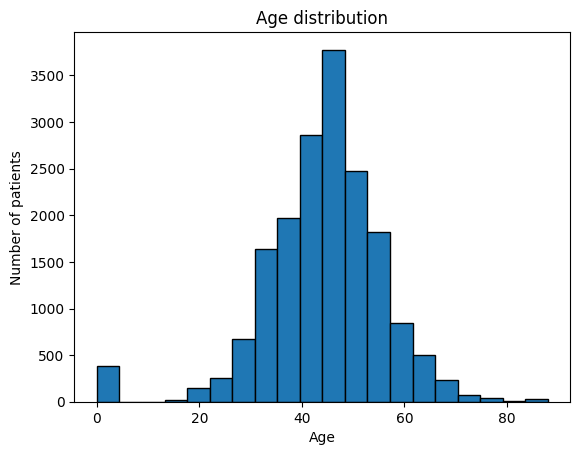

In [ ]:
'''histogramm for age quick chech age distribution
without missing data to be used as referece after filling the missing data to
make sure no change on the distribution'''
import matplotlib.pyplot as plt

plt.hist(merged_df["Patient's Age"].dropna(), bins=20, edgecolor='k')
plt.xlabel("Age")
plt.ylabel("Number of patients")
plt.title("Age distribution")
plt.show()


In [ ]:
''' checking if there is outliers or wrong age entry to help in deciding which is the
best way for ambutation  '''
Q1 = merged_df["Patient's Age"].quantile(0.25)
Q3 = merged_df["Patient's Age"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = merged_df[(merged_df["Patient's Age"] < lower_bound) |
                     (merged_df["Patient's Age"] > upper_bound)]

print(f"Number of outliers: {outliers.shape[0]}")
print(outliers["Patient's Age"].describe())


Number of outliers: 620
count    620.000000
mean      20.174194
std       31.520673
min        0.000000
25%        0.000000
50%        0.000000
75%       18.000000
max       88.000000
Name: Patient's Age, dtype: float64


In [ ]:
#based on histogram and other data , we will remove wrong age keep them as nan
import numpy as np
merged_df.loc[merged_df["Patient's Age"] <= 0, "Patient's Age"] = np.nan


In [ ]:
# median will be the way to fill the missing value because it it not affected by outliers
median_age = merged_df["Patient's Age"].median()
merged_df["Patient's Age"] = merged_df["Patient's Age"].fillna(median_age)

In [ ]:
# clarify the result
print(merged_df["Patient's Age"].isna().sum())
print(merged_df["Patient's Age"].dtype)


0
float64


In [ ]:
# recheck
merged_df["Patient's Age"].describe()

,Patient's Age
count,20000.000000
mean,45.091600
std,9.098404
min,14.000000
25%,40.000000
50%,45.000000
75%,50.000000
max,88.000000


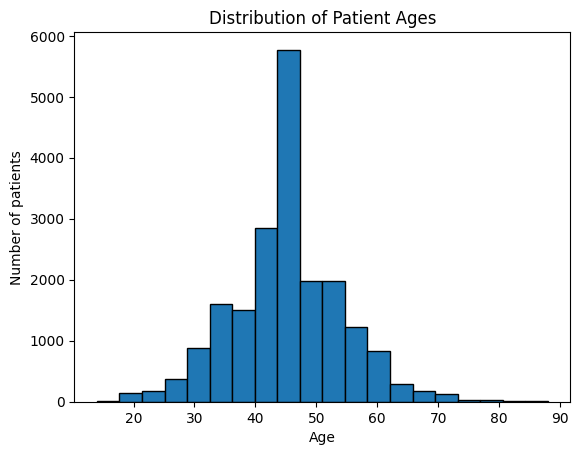

In [ ]:
# again recheck the redistribution

plt.hist(merged_df["Patient's Age"], bins=20, edgecolor='k')
plt.xlabel("Age")
plt.ylabel("Number of patients")
plt.title("Distribution of Patient Ages")
plt.show()


In [ ]:
skewness = merged_df["Patient's Age"].skew()
print(f"Skewness: {skewness:.2f}")


Skewness: 0.21


In [ ]:
'''categorize the ages into discrete age groups and then to show how many in each group.'''
age_bins = [20, 30, 40, 50, 60, 70, 80, 90]
age_labels = ['20-29','30-39','40-49','50-59','60-69','70-79','80-89']
merged_df['Age Group'] = pd.cut(merged_df["Patient's Age"], bins=age_bins, labels=age_labels, right=False)

# Count patients per group
print(merged_df['Age Group'].value_counts().sort_index())

Age Group
20-29     720
30-39    3840
40-49    9980
50-59    4024
60-69    1092
70-79     176
80-89      28
Name: count, dtype: int64


In [ ]:
# check the new shape for the datafram
merged_df.columns

Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density', 'split',
       'Series Instance UID', 'Patient's Age', 'View Position',
       'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns',
       'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value',
       'Pixel Padding Range Limit', 'Window Center', 'Window Width',
       'Rescale Intercept', 'Rescale Slope', 'Rescale Type',
       'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name', 'Age Group'],
      dtype='object')

In [ ]:
merged_df.shape

(20000, 30)

**# Now to move to the next feature which is the breast density**

In [ ]:
# will check the data type
merged_df['breast_density'].dtype

dtype('O')

In [ ]:
# them if there is missing data
merged_df['breast_density'].isna().sum()

np.int64(0)

In [ ]:
merged_df['breast_density'].isna().any()

np.False_

In [ ]:
# now we will check the values in the column
merged_df['breast_density'].unique()

array(['DENSITY C', 'DENSITY B', 'DENSITY D', 'DENSITY A'], dtype=object)

In [ ]:
# distribution of the breast sensity
merged_df['breast_density'].value_counts(dropna=False)


,count
breast_density,
DENSITY C,15292
DENSITY D,2700
DENSITY B,1908
DENSITY A,100


In [ ]:
# just to check the percentage
percent = merged_df['breast_density'].value_counts(normalize=True, dropna=False) * 100
print(percent)

breast_density
DENSITY C    76.46
DENSITY D    13.50
DENSITY B     9.54
DENSITY A     0.50
Name: proportion, dtype: float64


# Explore how the data splited based on values in 'split' column

In [ ]:
# check the missing value
merged_df['split'].isna().any()

np.False_

In [ ]:
# double check
merged_df['split'].isna().sum()

np.int64(0)

In [ ]:
# how the dataset was split
merged_df['split'].unique()

array(['training', 'test'], dtype=object)

In [ ]:
# check if splited as described by the dataset source 16000/4000 image
merged_df['split'].value_counts(dropna=False)

,count
split,
training,16000
test,4000


# Now we will move to the image file in the dataset

In [ ]:
''' the file was loaded to the drive as zip file we will ,
accsess it then show some image names'''
import zipfile
import pandas as pd

zip_path = "/content/drive/MyDrive/VinDr_mammo.png/images_png.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    image_files = [f for f in zip_ref.namelist() if f.endswith(".png")]


print(image_files[:5])


['0025a5dc99fd5c742026f0b2b030d3e9/2ddfad7286c2b016931ceccd1e2c7bbc.png', '0025a5dc99fd5c742026f0b2b030d3e9/451562831387e2822923204cf8f0873e.png', '0025a5dc99fd5c742026f0b2b030d3e9/47c8858666bcce92bcbd57974b5ce522.png', '0025a5dc99fd5c742026f0b2b030d3e9/fcf12c2803ba8dc564bf1287c0c97d9a.png', '0028fb2c7f0b3a5cb9a80cb0e1cdbb91/16e58fc1d65fa7587247e6224ee96527.png']


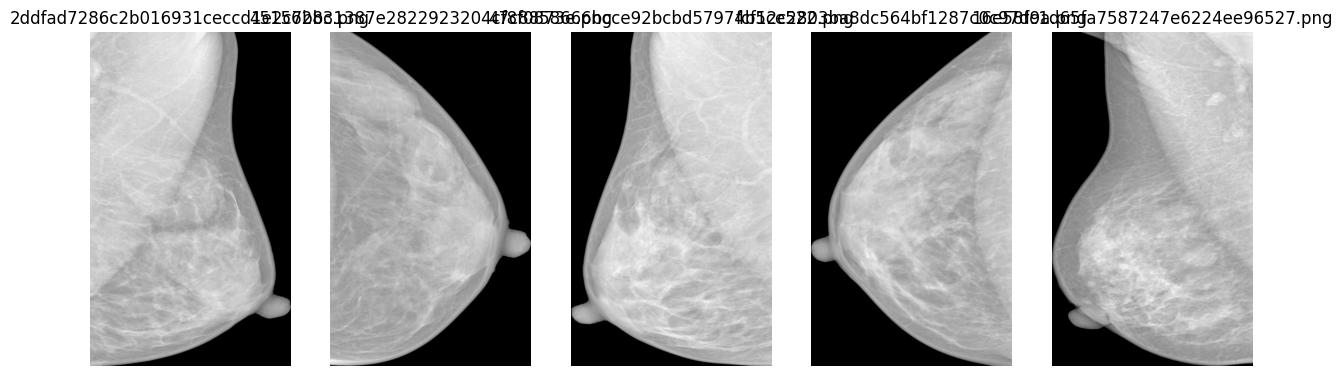

In [ ]:
# ilustrate first few image with the file name
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    plt.figure(figsize=(15, 5))
    for i, f in enumerate(image_files[:5]):
        img = Image.open(zip_ref.open(f))
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f.split('/')[-1])
        plt.axis('off')
    plt.show()

In [ ]:
''' i organize all images in the ZIP into a structured table.

Prepares for merging with annotations and metadata'''

image_data = []
for f in image_files:
    study_id, image_file = f.split('/')
    image_id = image_file.replace(".png", "")
    image_data.append({
        "study_id": study_id,
        "image_id": image_id,
        "image_path_in_zip": f
    })

images_df = pd.DataFrame(image_data)
print("Images DF shape:", images_df.shape)
images_df.head()


Images DF shape: (20000, 3)


,study_id,image_id,image_path_in_zip
0,0025a5dc99fd5c742026f0b2b030d3e9,2ddfad7286c2b016931ceccd1e2c7bbc,0025a5dc99fd5c742026f0b2b030d3e9/2ddfad7286c2b...
1,0025a5dc99fd5c742026f0b2b030d3e9,451562831387e2822923204cf8f0873e,0025a5dc99fd5c742026f0b2b030d3e9/451562831387e...
2,0025a5dc99fd5c742026f0b2b030d3e9,47c8858666bcce92bcbd57974b5ce522,0025a5dc99fd5c742026f0b2b030d3e9/47c8858666bcc...
3,0025a5dc99fd5c742026f0b2b030d3e9,fcf12c2803ba8dc564bf1287c0c97d9a,0025a5dc99fd5c742026f0b2b030d3e9/fcf12c2803ba8...
4,0028fb2c7f0b3a5cb9a80cb0e1cdbb91,16e58fc1d65fa7587247e6224ee96527,0028fb2c7f0b3a5cb9a80cb0e1cdbb91/16e58fc1d65fa...


In [ ]:
'''merges cleaned metadata/annotation DataFrame (merged_df) with the image DataFrame (images_df)
to create a single DataFrame that contains all relevant information for each image,
including its location in the ZIP, then show some rows'''

merged_df['study_id'] = merged_df['study_id'].astype(str)
merged_df['image_id'] = merged_df['image_id'].astype(str)
images_df['study_id'] = images_df['study_id'].astype(str)
images_df['image_id'] = images_df['image_id'].astype(str)


merged_df_with_images = merged_df.merge(images_df, on=['study_id','image_id'], how='left')
print("Merged DF shape:", merged_df_with_images.shape)
merged_df_with_images.head()


Merged DF shape: (20000, 31)


,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,...,Window Center,Window Width,Rescale Intercept,Rescale Slope,Rescale Type,Window Center & Width Explanation,Manufacturer,Manufacturer's Model Name,Age Group,image_path_in_zip
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training,...,1662,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,b8d273e8601f348d3664778dae0e7e0b/d8125545210c0...
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training,...,1664,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,b8d273e8601f348d3664778dae0e7e0b/290c658f4e75a...
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training,...,1600,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,b8d273e8601f348d3664778dae0e7e0b/cd0fc7bc53ac6...
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training,...,1654,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,b8d273e8601f348d3664778dae0e7e0b/71638b1e85379...
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,1580,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,40-49,8269f5971eaca3e5d3772d1796e6bd7a/dd9ce3288c077...


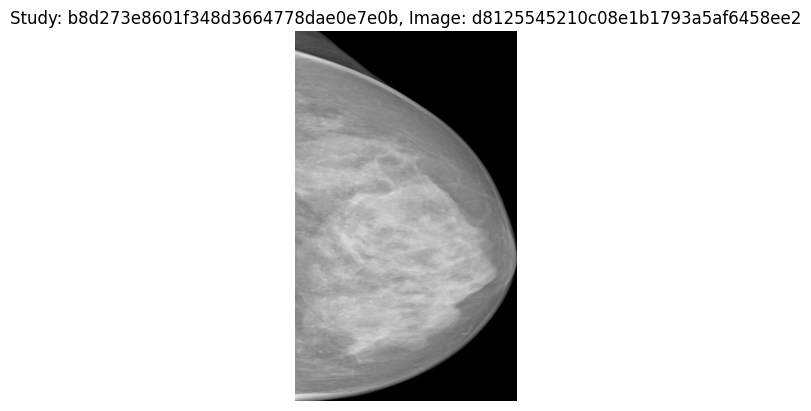

In [ ]:
# show image from the ZIP archive using thenew merged DataFrame
from PIL import Image
import matplotlib.pyplot as plt


sample_row = merged_df_with_images.iloc[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    img = Image.open(zip_ref.open(sample_row['image_path_in_zip']))
    plt.imshow(img, cmap='gray')
    plt.title(f"Study: {sample_row['study_id']}, Image: {sample_row['image_id']}")
    plt.axis('off')
    plt.show()


In [ ]:
# check if error (duplicate occures )
duplicates_exist = merged_df_with_images['image_id'].duplicated().any()
print("Are there duplicates in 'image_id'? ->", duplicates_exist)


Are there duplicates in 'image_id'? -> False


In [ ]:
#saves final merged DataFrame (merged_df_with_images) to a CSV file

save_path = "/content/drive/MyDrive/VinDr_mammo.png/mergedimage.csv"


merged_df_with_images.to_csv(save_path, index=False)

print(f"File saved to: {save_path}")


File saved to: /content/drive/MyDrive/VinDr_mammo.png/mergedimage.csv


In [ ]:
# check the shape after adding the new column
merged_df_with_images.shape

(20000, 31)

In [ ]:
#prepare the environment for extracting images and linking them to CSV file
import zipfile
import os
import pandas as pd
zip_path = "/content/drive/MyDrive/VinDr_mammo.png/images_png.zip"
unzip_folder = "/content/drive/MyDrive/VinDr_mammo.png/VinDr_mammo_unzipped"
os.makedirs(unzip_folder, exist_ok=True)

csv_path = "/content/drive/MyDrive/VinDr_mammo.png/mergedimage.csv"

In [ ]:
'''I will extract the image from the zip file so they can be easily accessed,
 visualized, and used for model training.'''
print("Starting unzip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder)
print(f"Unzipping completed! Images are saved in:\n{unzip_folder}")


Starting unzip...
Unzipping completed! Images are saved in:
/content/drive/MyDrive/VinDr_mammo.png/VinDr_mammo_unzipped


In [ ]:
# reload previously saved merged dataset (metadata + annotations + image paths)
# ------------------------------
merged_df = pd.read_csv(csv_path)
print("CSV loaded. Sample rows:")
print(merged_df.head())

CSV loaded. Sample rows:
                           study_id                         series_id  \
0  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
1  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
2  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
3  b8d273e8601f348d3664778dae0e7e0b  b36517b9cbbcfd286a7ae04f643af97a   
4  8269f5971eaca3e5d3772d1796e6bd7a  d931832a0815df082c085b6e09d20aac   

                           image_id laterality view_position  height  width  \
0  d8125545210c08e1b1793a5af6458ee2          L            CC    3518   2800   
1  290c658f4e75a3f83ec78a847414297c          L           MLO    3518   2800   
2  cd0fc7bc53ac632a11643ac4cc91002a          R            CC    3518   2800   
3  71638b1e853799f227492bfb08a01491          R           MLO    3518   2800   
4  dd9ce3288c0773e006a294188aadba8e          L            CC    3518   2800   

  breast_birads breast_density     split  ... Window Center  

In [ ]:
'''creates the full file path to each mammography image on disk and stores it in dataset this will be easier for
tabular data to physical image files,DL training and better for pipeline reproducibility'''
merged_df['image_path'] = merged_df.apply(
    lambda row: os.path.join(unzip_folder, row['study_id'], f"{row['image_id']}.png"),
    axis=1
)

In [ ]:
# lets check
print("Sample mapping of study_id, image_id, image_path:")
print(merged_df[['study_id','image_id','image_path']].head())


Sample mapping of study_id, image_id, image_path:
                           study_id                          image_id  \
0  b8d273e8601f348d3664778dae0e7e0b  d8125545210c08e1b1793a5af6458ee2   
1  b8d273e8601f348d3664778dae0e7e0b  290c658f4e75a3f83ec78a847414297c   
2  b8d273e8601f348d3664778dae0e7e0b  cd0fc7bc53ac632a11643ac4cc91002a   
3  b8d273e8601f348d3664778dae0e7e0b  71638b1e853799f227492bfb08a01491   
4  8269f5971eaca3e5d3772d1796e6bd7a  dd9ce3288c0773e006a294188aadba8e   

                                          image_path  
0  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
1  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
2  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
3  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
4  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  


In [ ]:
# recheck in another way
sample_path = merged_df.iloc[0]['image_path']
print("Does the first image exist?", os.path.exists(sample_path))


Does the first image exist? True


Found 5000 studies.
Found 20000 images in total.


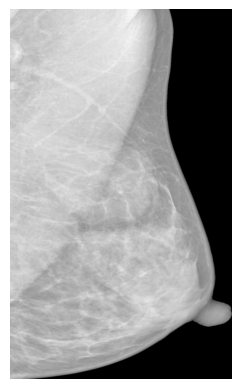

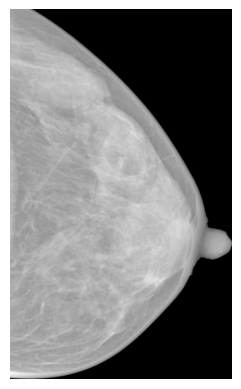

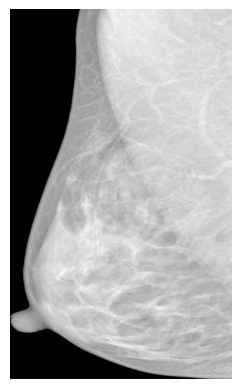

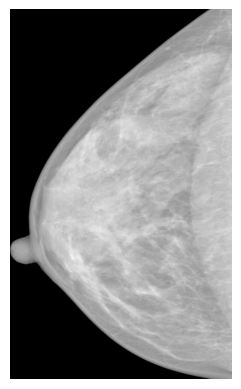

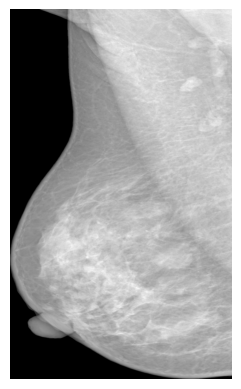

In [ ]:
#dataset check and visual inspection of the unzipped mammography images
import os
from PIL import Image
import matplotlib.pyplot as plt

'''Path where all mammography images were extracted.

Each subfolder corresponds to one study/exam.'''
unzipped_folder = "/content/drive/MyDrive/VinDr_mammo.png/VinDr_mammo_unzipped"

#  to scan each folder
study_folders = [os.path.join(unzipped_folder, f) for f in os.listdir(unzipped_folder) if os.path.isdir(os.path.join(unzipped_folder, f))]

print(f"Found {len(study_folders)} studies.")

# collects all mammography image files
all_images = []  #create empty list
for study in study_folders:
    images = [os.path.join(study, img) for img in os.listdir(study) if img.endswith('.png')]
    all_images.extend(images)

print(f"Found {len(all_images)} images in total.")

# show a few images
for img_path in all_images[:5]:
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


In [ ]:


csv_path = "/content/drive/MyDrive/VinDr_mammo.png/mergedimage.csv"

# check only the feature
df = pd.read_csv(csv_path, nrows=0)

print(df.columns.tolist())


['study_id', 'series_id', 'image_id', 'laterality', 'view_position', 'height', 'width', 'breast_birads', 'breast_density', 'split', 'Series Instance UID', "Patient's Age", 'View Position', 'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns', 'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value', 'Pixel Padding Range Limit', 'Window Center', 'Window Width', 'Rescale Intercept', 'Rescale Slope', 'Rescale Type', 'Window Center & Width Explanation', 'Manufacturer', "Manufacturer's Model Name", 'Age Group', 'image_path_in_zip']


In [ ]:
#enhances CSV file by including the full file paths of all images in the unzipped folder,
# defining the path
root_folder = "/content/drive/MyDrive/VinDr_mammo.png"
unzipped_folder = os.path.join(root_folder, "VinDr_mammo_unzipped")
csv_path = os.path.join(root_folder, "mergedimage.csv")

# reload
merged_df = pd.read_csv(csv_path)


'''Loops over every row and replaces the old image_path_in_zip
column with a new one that points to the physical unzipped image
but keep the name of the column the same.'''

merged_df['image_path_in_zip'] = merged_df.apply(
    lambda row: os.path.join(unzipped_folder, row['study_id'], f"{row['image_id']}.png"),
    axis=1
)

# Check first few rows
print(merged_df[['study_id','image_id','image_path_in_zip']].head())

# then saved to the csv file
merged_df.to_csv(os.path.join(root_folder, "mergedimage_with_path.csv"), index=False)
''' If we open mergedimage_with_path.csv, image_path_in_zip will point to the physical unzipped images, not the ZIP file'''


                           study_id                          image_id  \
0  b8d273e8601f348d3664778dae0e7e0b  d8125545210c08e1b1793a5af6458ee2   
1  b8d273e8601f348d3664778dae0e7e0b  290c658f4e75a3f83ec78a847414297c   
2  b8d273e8601f348d3664778dae0e7e0b  cd0fc7bc53ac632a11643ac4cc91002a   
3  b8d273e8601f348d3664778dae0e7e0b  71638b1e853799f227492bfb08a01491   
4  8269f5971eaca3e5d3772d1796e6bd7a  dd9ce3288c0773e006a294188aadba8e   

                                   image_path_in_zip  
0  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
1  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
2  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
3  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  
4  /content/drive/MyDrive/VinDr_mammo.png/VinDr_m...  


In [ ]:
merged_df.columns

Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density', 'split',
       'Series Instance UID', 'Patient's Age', 'View Position',
       'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns',
       'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value',
       'Pixel Padding Range Limit', 'Window Center', 'Window Width',
       'Rescale Intercept', 'Rescale Slope', 'Rescale Type',
       'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name', 'Age Group', 'image_path_in_zip'],
      dtype='object')

In [ ]:
merged_df.shape

(20000, 31)

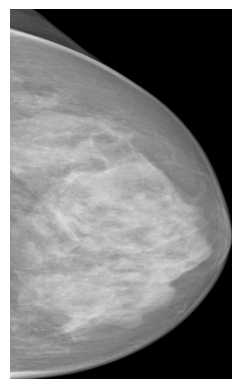

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Get image path from your DataFrame
img_path = merged_df.loc[0, 'image_path_in_zip']

# Open the image
img = Image.open(img_path)

# Display in notebook
plt.imshow(img, cmap='gray')  # mammograms are grayscale
plt.axis('off')
plt.show()


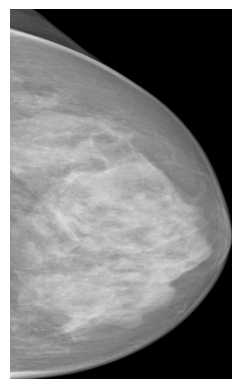

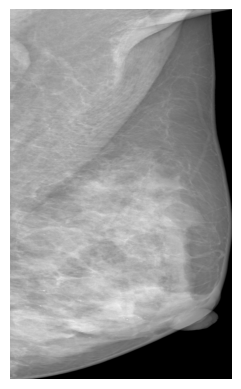

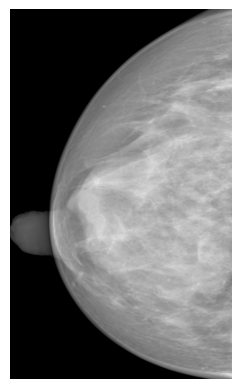

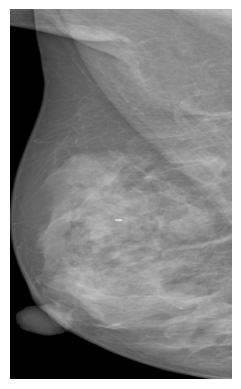

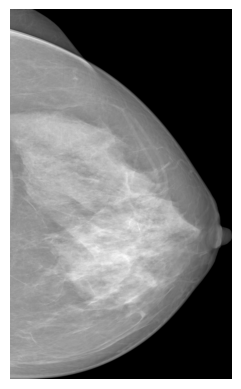

In [ ]:
for img_path in merged_df['image_path_in_zip'][:5]:
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()


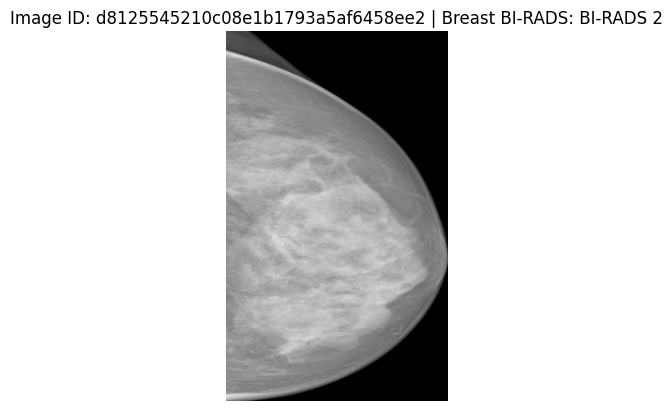

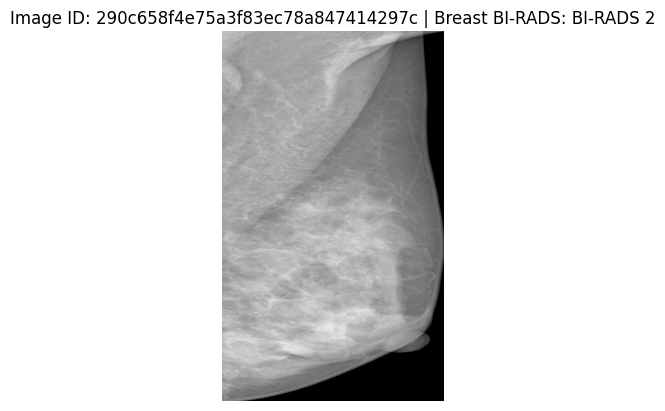

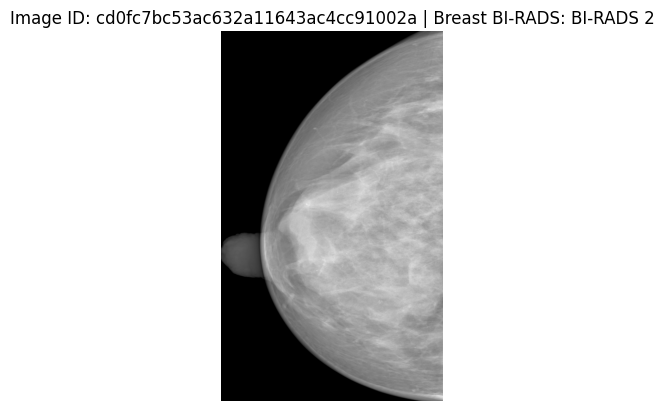

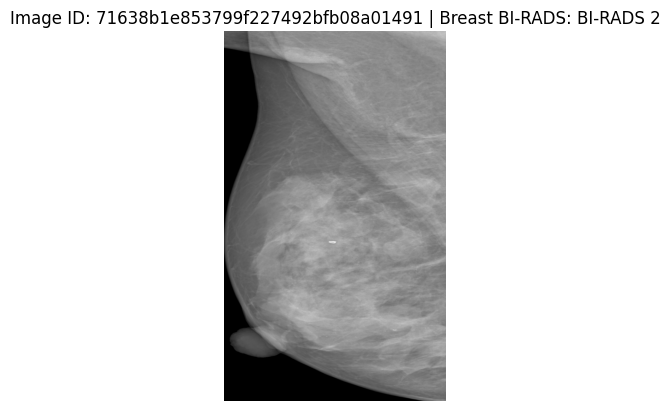

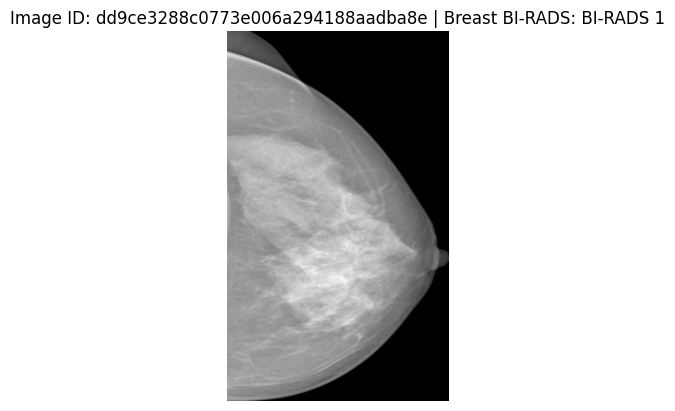

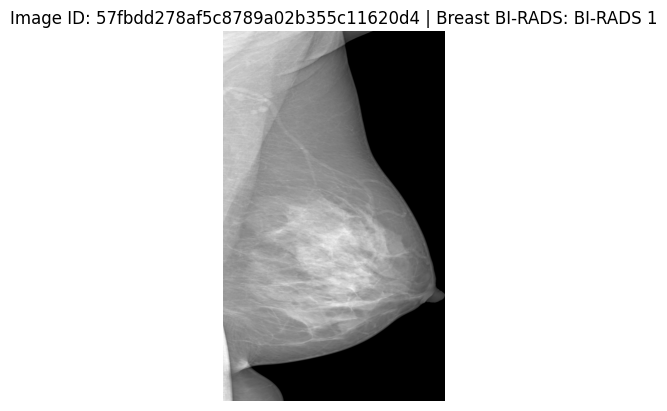

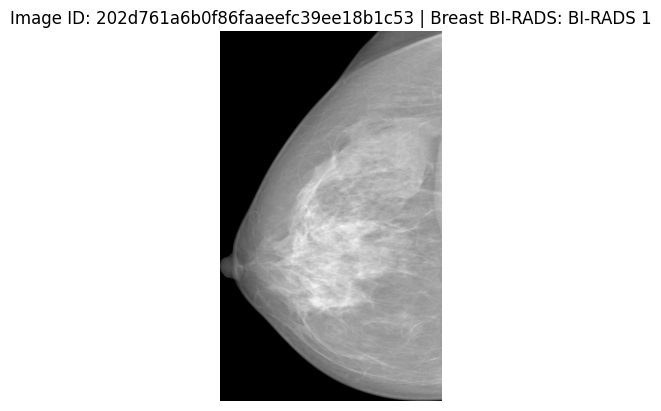

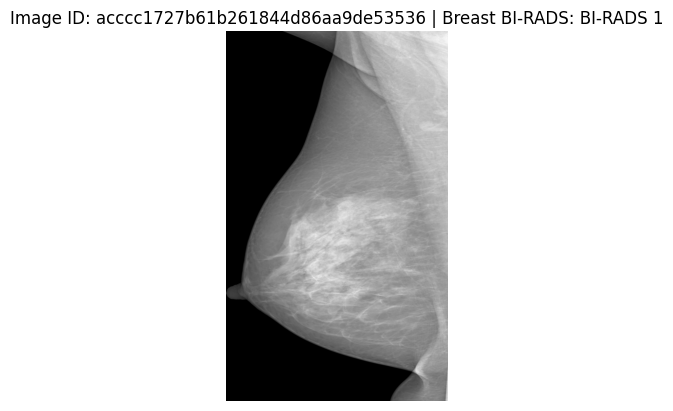

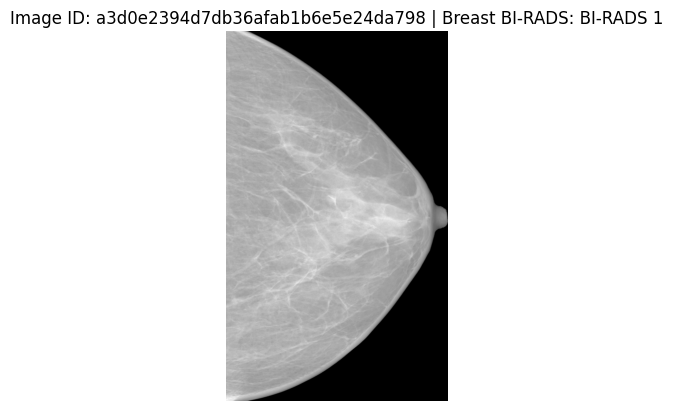

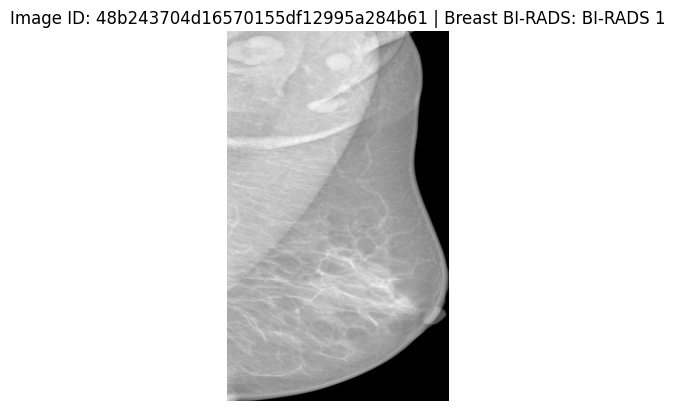

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Loop through first N images (e.g., 10)
N = 10
for i in range(N):
    row = merged_df.iloc[i]
    img_path = row['image_path_in_zip']
    image_id = row['image_id']
    breast_birads = row['breast_birads']

    # Open image
    img = Image.open(img_path)

    # Display
    plt.imshow(img, cmap='gray')
    plt.title(f"Image ID: {image_id} | Breast BI-RADS: {breast_birads}")
    plt.axis('off')
    plt.show()


**Exploratory Data Analysis (EDA)**

In [ ]:
# general data inspection
import pandas as pd

csv_path = "/content/drive/MyDrive/VinDr_mammo.png/mergedimage_with_path.csv"
df = pd.read_csv(csv_path)
df.info()# sumarize the dataset
df.head()#Displays the first few rows of the dataset.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   study_id                           20000 non-null  object 
 1   series_id                          20000 non-null  object 
 2   image_id                           20000 non-null  object 
 3   laterality                         20000 non-null  object 
 4   view_position                      20000 non-null  object 
 5   height                             20000 non-null  int64  
 6   width                              20000 non-null  int64  
 7   breast_birads                      20000 non-null  object 
 8   breast_density                     20000 non-null  object 
 9   split                              20000 non-null  object 
 10  Series Instance UID                20000 non-null  object 
 11  Patient's Age                      20000 non-null  flo

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,...,Window Center,Window Width,Rescale Intercept,Rescale Slope,Rescale Type,Window Center & Width Explanation,Manufacturer,Manufacturer's Model Name,Age Group,image_path_in_zip
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training,...,1662,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,/content/drive/MyDrive/VinDr_mammo.png/VinDr_m...
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training,...,1664,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,/content/drive/MyDrive/VinDr_mammo.png/VinDr_m...
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training,...,1600,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,/content/drive/MyDrive/VinDr_mammo.png/VinDr_m...
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training,...,1654,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,50-59,/content/drive/MyDrive/VinDr_mammo.png/VinDr_m...
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,...,1580,1500,0,1,US,linear LUT,SIEMENS,Mammomat Inspiration,40-49,/content/drive/MyDrive/VinDr_mammo.png/VinDr_m...


In [ ]:
df.columns

Index(['study_id', 'series_id', 'image_id', 'laterality', 'view_position',
       'height', 'width', 'breast_birads', 'breast_density', 'split',
       'Series Instance UID', 'Patient's Age', 'View Position',
       'Image Laterality', 'Photometric Interpretation', 'Rows', 'Columns',
       'Imager Pixel Spacing', 'Pixel Spacing', 'Pixel Padding Value',
       'Pixel Padding Range Limit', 'Window Center', 'Window Width',
       'Rescale Intercept', 'Rescale Slope', 'Rescale Type',
       'Window Center & Width Explanation', 'Manufacturer',
       'Manufacturer's Model Name', 'Age Group', 'image_path_in_zip'],
      dtype='object')

In [ ]:


# Count missing values for each column
missing_summary = df.isna().sum().sort_values(ascending=False)

# Display nicely
print("🧮 Missing Values Summary (Top → Bottom):\n")
print(missing_summary)
print("\n✅ Total rows:", len(df))
print("\n📊 Missing values (%):\n")
print((df.isna().sum() / len(df) * 100).round(2))


🧮 Missing Values Summary (Top → Bottom):

Pixel Padding Range Limit            19040
Pixel Spacing                        16128
Age Group                              140
laterality                               0
study_id                                 0
series_id                                0
image_id                                 0
breast_birads                            0
breast_density                           0
split                                    0
Series Instance UID                      0
Patient's Age                            0
view_position                            0
height                                   0
width                                    0
Photometric Interpretation               0
Image Laterality                         0
View Position                            0
Columns                                  0
Imager Pixel Spacing                     0
Pixel Padding Value                      0
Window Center                            0
Rows        

In [ ]:
# I will check why i have missing data in the Age Group

# show rows where 'Age Group' is missing
missing_age_group = df[df['Age Group'].isna()]
print(missing_age_group)

# display the needed column
print(missing_age_group[['study_id', 'image_id', "Patient's Age", 'Age Group', 'breast_density']])


                               study_id                         series_id  \
1260   788eeb3a71ff18772afffbab5aa28ee2  202ea894dd45662d2301119fb98e2628   
1261   788eeb3a71ff18772afffbab5aa28ee2  202ea894dd45662d2301119fb98e2628   
1262   788eeb3a71ff18772afffbab5aa28ee2  202ea894dd45662d2301119fb98e2628   
1263   788eeb3a71ff18772afffbab5aa28ee2  202ea894dd45662d2301119fb98e2628   
5120   4c4b2aae9062c2fdb7a2bbdf48dc093e  0541f6e48030dd964b58658d3f082d52   
...                                 ...                               ...   
19491  9cfb76bb4c75fb2cb7e3a8de11f5a50b  33f2b23a9664e91bec258e5547215eb3   
19996  b3c8969cd2accfa4dbb2aece1f7158ab  69d7f07ea04572dad5e5aa62fbcfc4b7   
19997  b3c8969cd2accfa4dbb2aece1f7158ab  69d7f07ea04572dad5e5aa62fbcfc4b7   
19998  b3c8969cd2accfa4dbb2aece1f7158ab  69d7f07ea04572dad5e5aa62fbcfc4b7   
19999  b3c8969cd2accfa4dbb2aece1f7158ab  69d7f07ea04572dad5e5aa62fbcfc4b7   

                               image_id laterality view_position  height  \

In [ ]:
# some age not included in the age groups ,so, i will define new bins including <20 and ≥90
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 120]  # 0–20, 20–29, ..., 90+
age_labels = ['<20','20-29','30-39','40-49','50-59','60-69','70-79','80-89','90+']

# Fill missing Age Group based on Patient's Age
df['Age Group'] = pd.cut(
    df["Patient's Age"],
    bins=age_bins,
    labels=age_labels,
    right=False
)

In [ ]:
# recheck the missing
print("Remaining missing Age Group:", df['Age Group'].isna().sum())

Remaining missing Age Group: 0


In [ ]:
# recheck the data balance
print("Breast BIRADS counts:\n", df['breast_birads'].value_counts(), "\n")
print("Breast Density counts:\n", df['breast_density'].value_counts(), "\n")
print("Age Group counts:\n", df['Age Group'].value_counts(), "\n")

Breast BIRADS counts:
 breast_birads
BI-RADS 1    13406
BI-RADS 2     4676
BI-RADS 3      930
BI-RADS 4      762
BI-RADS 5      226
Name: count, dtype: int64 

Breast Density counts:
 breast_density
DENSITY C    15292
DENSITY D     2700
DENSITY B     1908
DENSITY A      100
Name: count, dtype: int64 

Age Group counts:
 Age Group
40-49    9980
50-59    4024
30-39    3840
60-69    1092
20-29     720
70-79     176
<20       140
80-89      28
90+         0
Name: count, dtype: int64 



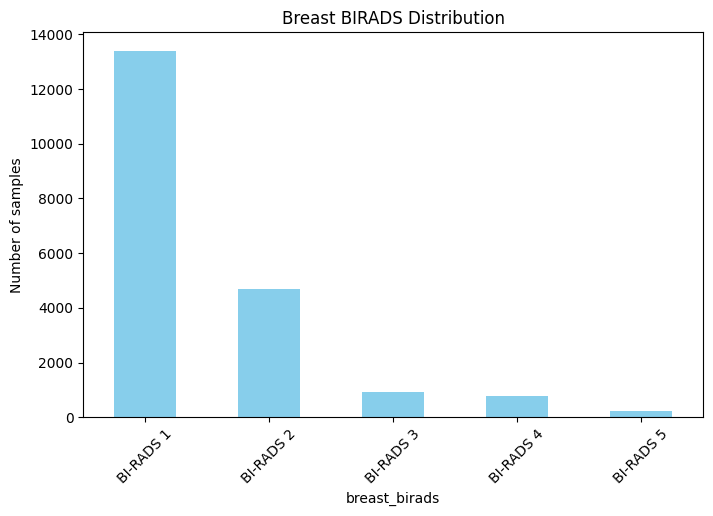

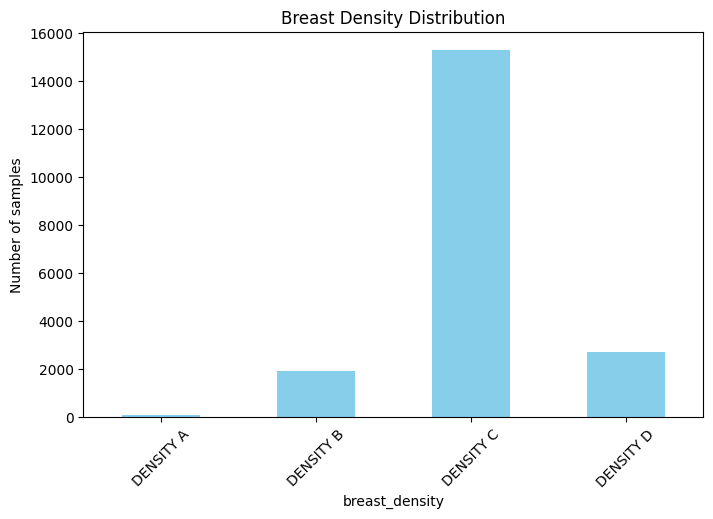

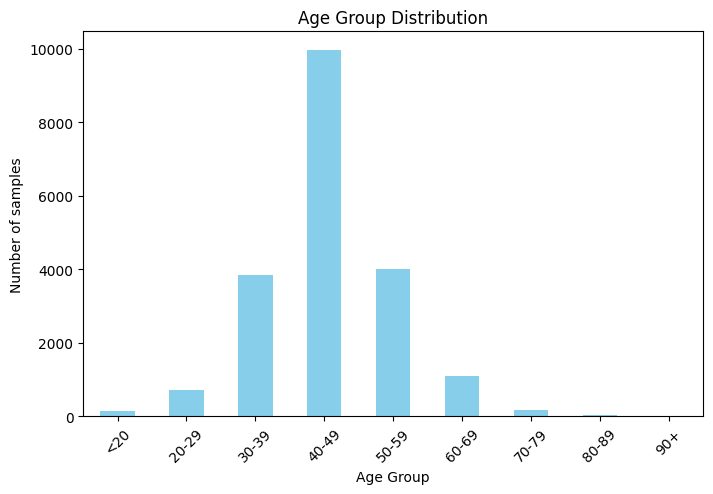

In [ ]:
import matplotlib.pyplot as plt
# Set up plotting function
def plot_counts(column, title):
    counts = df[column].value_counts().sort_index()
    counts.plot(kind='bar', figsize=(8,5), color='skyblue')
    plt.title(title)
    plt.ylabel('Number of samples')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.show()

# Plot graphs
plot_counts('breast_birads', 'Breast BIRADS Distribution')
plot_counts('breast_density', 'Breast Density Distribution')
plot_counts('Age Group', 'Age Group Distribution')

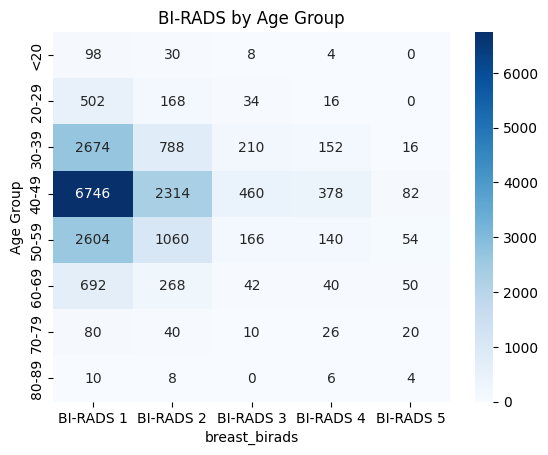

In [ ]:
'''visualize how BI-RADS categories are distributed across age groups,
which wich gives idea about fairnes '''
import seaborn as sns

age_birads = pd.crosstab(df['Age Group'], df['breast_birads'])
sns.heatmap(age_birads, annot=True, fmt='d', cmap='Blues')
plt.title("BI-RADS by Age Group")
plt.show()


In [ ]:

age_skew = df["Patient's Age"].skew()
print("Skewness of Patient's Age:", age_skew)


Skewness of Patient's Age: 0.2074966815799787


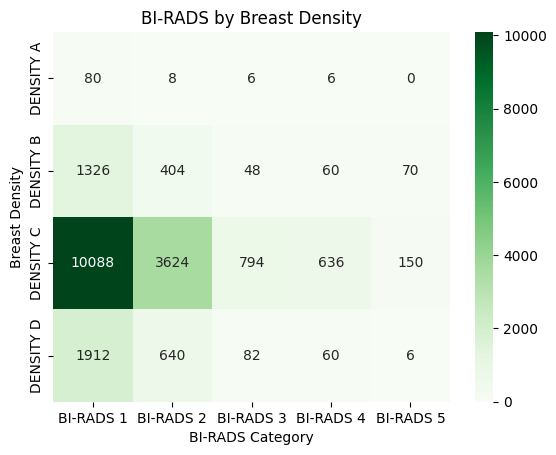

In [ ]:
'''visualize how BI-RADS categories are distributed across breast density,
which wich gives idea about fairnes '''
density_birads = pd.crosstab(df['breast_density'], df['breast_birads'])

# Heatmap
sns.heatmap(density_birads, annot=True, fmt='d', cmap='Greens')
plt.title("BI-RADS by Breast Density")
plt.xlabel("BI-RADS Category")
plt.ylabel("Breast Density")
plt.show()

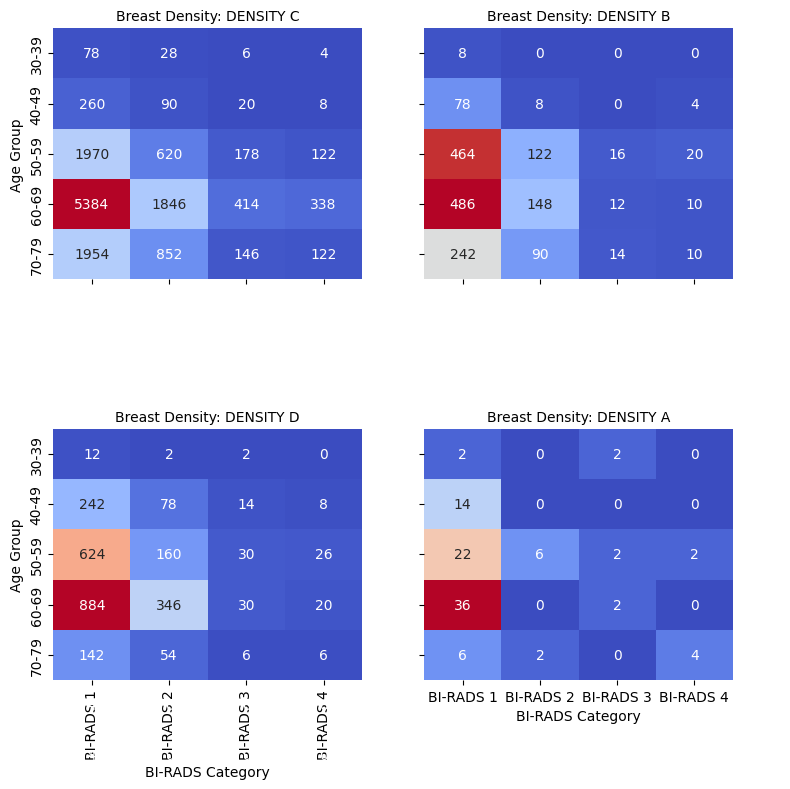

In [ ]:
'''more advanced how BI-RADS distributions vary across age groups within each breast density category.'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the data to long format for easier plotting
df_long = df[['Age Group', 'breast_density', 'breast_birads']]

# Create a pivot table for each breast density
g = sns.FacetGrid(df_long, col="breast_density", col_wrap=2, height=4, sharex=True, sharey=True)
g.map_dataframe(lambda data, color: sns.heatmap(
    pd.crosstab(data['Age Group'], data['breast_birads']),
    annot=True, fmt='d', cmap='coolwarm', cbar=False
))

# Add titles
g.set_titles(col_template="Breast Density: {col_name}")
g.set_axis_labels("BI-RADS Category", "Age Group")

plt.tight_layout()
plt.show()


In [ ]:

# numirical analysis
table = pd.crosstab(
    [df['Age Group']],        # Rows
    [df['breast_density'], df['breast_birads']]  # Columns (multi-index)
)

# show the table
print("BI-RADS counts by Age Group and Breast Density:\n")
print(table)

BI-RADS counts by Age Group and Breast Density:

breast_density DENSITY A                               DENSITY B            \
breast_birads  BI-RADS 1 BI-RADS 2 BI-RADS 3 BI-RADS 4 BI-RADS 1 BI-RADS 2   
Age Group                                                                    
<20                    0         0         0         0         8         0   
20-29                  0         0         0         0         0         0   
30-39                  2         0         2         0        78         8   
40-49                 14         0         0         0       464       122   
50-59                 22         6         2         2       486       148   
60-69                 36         0         2         0       242        90   
70-79                  6         2         0         4        46        28   
80-89                  0         0         0         0         2         8   

breast_density                               DENSITY C                      \
breast_birads 

Split data based on its 'split' values

In [ ]:
# to confirm the values in 'split' and count them
unique_splits = df['split'].unique()
print("Unique splits:", unique_splits)

split_counts = df['split'].value_counts()
print("\nCounts per split:\n", split_counts)


Unique splits: ['training' 'test']

Counts per split:
 split
training    16000
test         4000
Name: count, dtype: int64


In [ ]:
# separate  into training and test sets based on the 'split' column
train_df = df[df['split'] == 'training']
test_df = df[df['split'] == 'test']

# Save each set to a separate CSV file  to facilitate the dealing with
train_output_path = "/content/drive/MyDrive/VinDr_mammo.png/training_samples.csv"
test_output_path = "/content/drive/MyDrive/VinDr_mammo.png/test_samples.csv"

train_df.to_csv(train_output_path, index=False)
test_df.to_csv(test_output_path, index=False)

# Confirm
print(f"✅ Training set saved: {train_output_path} (rows: {len(train_df)})")
print(f"✅ Test set saved: {test_output_path} (rows: {len(test_df)})")

✅ Training set saved: /content/drive/MyDrive/VinDr_mammo.png/training_samples.csv (rows: 16000)
✅ Test set saved: /content/drive/MyDrive/VinDr_mammo.png/test_samples.csv (rows: 4000)
